In [3]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import transforms

from origindataset import OriginDataset,Compose
from dataaug import DataAug
from segdataset import SegDataset
from unet import UNet
from testdataset import TestDataset

import os
import matplotlib.pyplot as plt

# Augmentation

In [3]:
transform_aug = Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.RandomVerticalFlip(p=1),
    transforms.Resize((1000, 1000)),
    transforms.RandomResizedCrop((512, 512)),
    transforms.ToTensor()
])

original_dataset = OriginDataset('./data/train/image','./data/train/label',transform=transform_aug)
original_loader = DataLoader(original_dataset, batch_size = 1, shuffle = True, pin_memory = True)

aug_num = 100
DataAug(original_loader,aug_num,aug_path='./data/train/aug/')

# Training set loader

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = SegDataset('./data/train/aug',transform=transform)
train_loader = DataLoader(train_dataset, batch_size = 2, shuffle = True, pin_memory = True)

# Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

unet = UNet().to(device)

unet.to(device)

criterion = nn.BCELoss().cuda()
optimizer = optim.Adam(unet.parameters(),lr=1e-4)

decayRate = 0.95
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

iteration = 0
iterations = []
loss_trains = []
loss_valids = []

correct_valid = 0
total_valid = 0
correct_train = 0
total_train = 0

for epoch in range(30): 
    running_loss_train = 0.0

    for i, data in enumerate(train_loader, 0):
        unet.train()
        input_train, label_train = data
        del data
        input_train, label_train = input_train.to(device).float(), label_train.to(device).float()
     
        optimizer.zero_grad()
        pred_train = unet(input_train)
   
        loss_train = criterion(pred_train, label_train)

        loss_train.backward()
        optimizer.step()
            
        iteration += 1
        running_loss_train += loss_train.item()

        loss_trains.append(running_loss_train/iteration)

        iterations.append(iteration)

        print('[%d, %5d] loss_t: %.3f, - iteration : %d' %
              (epoch + 1, i + 1, running_loss_train/iteration, iteration))

    running_loss_train = 0.0
    iteration = 0
    
    save_path = "./unet_result.pth"
    torch.save(unet.state_dict(), save_path) 
    
    lr_scheduler.step()
    
print('Finished Training')

Text(0.5, 0, 'Iterations')

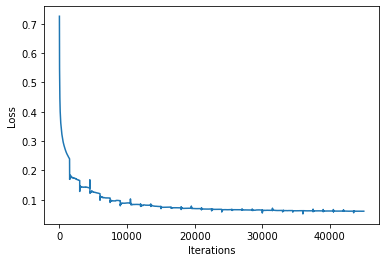

In [22]:
import matplotlib.pyplot as plt
plt.plot(loss_trains)
plt.ylabel('Loss')
plt.xlabel('Iterations')

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

path_test = './data/test'
test_dataset = TestDataset(path_test,transform=transform)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = False)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

unet = UNet().to(device)
save_path = "./unet_result.pth"
unet.load_state_dict(torch.load(save_path))

unet.eval()
unet.to(device)

test_img = []
test_mask = []
cnt = 0

with torch.no_grad():
    for i, input_test in enumerate(test_loader, 0):

        input_test = input_test.to(device).float()

        pred_test = unet(input_test)
        
        pred_test[pred_test >= 0.5] = 1
        pred_test[pred_test < 0.5] = 0
        
        input_test = input_test.cpu()
        pred_test = pred_test.cpu()
        trans = transforms.ToPILImage()
        
        image_input = trans(input_test[0][0])
        image_pred = trans(pred_test[0][0])
        image_pred.save(os.path.join(path_test,str(cnt)+'_pred.jpg'))
        
        test_img.append(image_input)
        test_mask.append(image_pred)
        cnt += 1
print('Finish')

Finish


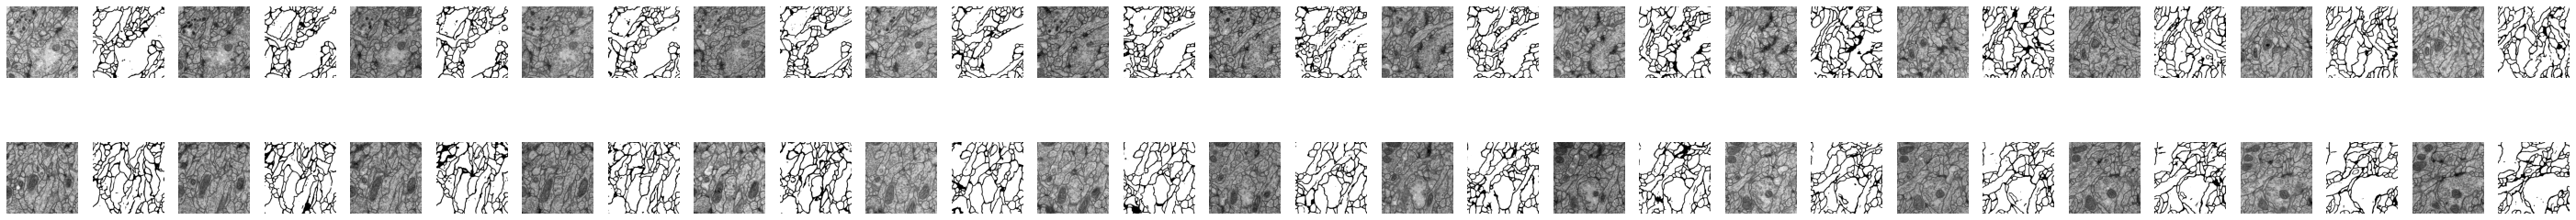

In [20]:
plt.figure(figsize=[50,5])
cnt = 0
for col in range(30):
    for row in range(2):
        cnt += 1
        if row == 0:
            plt.subplot(2,30,cnt)
            plt.imshow(test_img[col],'gray')
        else:
            plt.subplot(2,30,cnt)
            plt.imshow(test_mask[col],'gray')
        plt.axis('off')

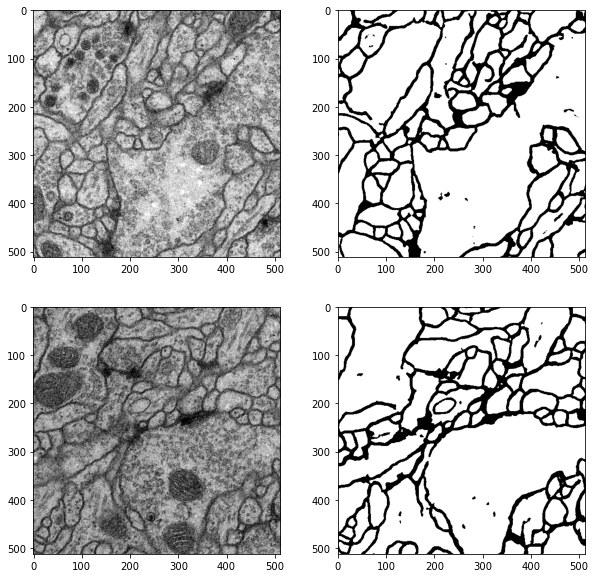

In [21]:
plt.figure(figsize=[10,10])

plt.subplot(2,2,1)
plt.imshow(test_img[0],'gray')
plt.subplot(2,2,2)
plt.imshow(test_mask[0],'gray')
plt.subplot(2,2,3)
plt.imshow(test_img[-1],'gray')
plt.subplot(2,2,4)
plt.imshow(test_mask[-1],'gray')